## Homework 1 - Predicting voting behavior based on Obesity-index  
## Problem 2.7

### First lets get an overview of the present data:

In [52]:
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt

df_2000 = pd.read_csv("data/obesity_election_2000.csv")
df_2000["obesity_index"] = df_2000["obesity_index"].str.rstrip("%").astype(float)

df_2004 = pd.read_csv("data/obesity_election_2004.csv")
df_2004["obesity_index"] = df_2004["obesity_index"].str.rstrip("%").astype(float)

df_2000.head()


,state,obesity_index,vote,abbrv
0,Alabama,22.6,R,AL
1,Alaska,20.9,R,AK
2,Arizona,14.9,R,AZ
3,Arkansas,21.9,R,AR
4,California,18.7,D,CA


In [53]:
import numpy as np

df_2000["vote"] = df_2000["vote"].str.strip().str[0].str.upper()           # 'D' or 'R'
s = pd.to_numeric(df_2000["obesity_index"].astype(str).str.rstrip("%"), errors="coerce")
df_2000["obesity_frac"] = s / 100.0 


centers = {"D": 0.0, "R": 1.0}
rng = np.random.default_rng(42)
df_2000["xpos"] = df_2000["vote"].map(centers) + rng.uniform(-0.18, 0.18, len(df_2000))

fig_2000 = px.scatter(
    df_2000, x="xpos", y="obesity_frac", color="vote", hover_name="state",
    color_discrete_map={"D":"#1f77b4","R":"#d62728"},
    labels={"obesity_frac":"Obesity index"},
    title="Year 2000 Election",
)
fig_2000.update_traces(marker=dict(size=9, opacity=0.85))

fig_2000.update_xaxes(
    tickmode="array",
    tickvals=[0, 1],
    ticktext=["Democrat", "Republican"],
    range=[-0.5, 1.5],
    title=""
)
fig_2000.update_yaxes(tickformat=".0%", title="Obesity index", rangemode="tozero")
fig_2000.show()


df_2004["vote"] = df_2004["vote"].str.strip().str[0].str.upper()           # 'D' or 'R'
s = pd.to_numeric(df_2004["obesity_index"].astype(str).str.rstrip("%"), errors="coerce")
df_2004["obesity_frac"] = s / 100.0 

centers = {"D": 0.0, "R": 1.0}
rng = np.random.default_rng(42)
df_2004["xpos"] = df_2004["vote"].map(centers) + rng.uniform(-0.18, 0.18, len(df_2004))

fig_2004 = px.scatter(
    df_2004, x="xpos", y="obesity_frac", color="vote", hover_name="state",
    color_discrete_map={"D":"#1f77b4","R":"#d62728"},
    labels={"obesity_frac":"obesity index"},
    title="Year 2004 Election",
)
fig_2004.update_traces(marker=dict(size=9, opacity=0.85))

fig_2004.update_xaxes(
    tickmode="array",
    tickvals=[0, 1],
    ticktext=["Democrat", "Republican"],
    range=[-0.5, 1.5],
    title=""
)
fig_2004.update_yaxes(tickformat=".0%", title="Obesity index", rangemode="tozero")
fig_2004.show()

### Now lets build the classifier:
#### Start with determining which is the optimal value for k:

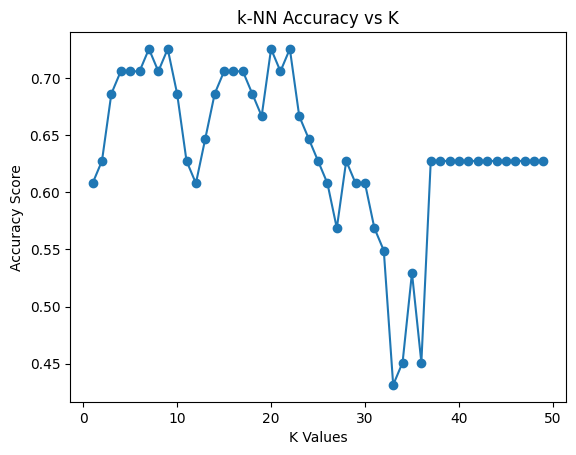

|   k |   LOOCV_accuracy |
|----:|-----------------:|
|   1 |           0.6078 |
|   2 |           0.6275 |
|   3 |           0.6863 |
|   4 |           0.7059 |
|   5 |           0.7059 |
|   6 |           0.7059 |
|   7 |           0.7255 |
|   8 |           0.7059 |
|   9 |           0.7255 |
|  10 |           0.6863 |
|  11 |           0.6275 |
|  12 |           0.6078 |
|  13 |           0.6471 |
|  14 |           0.6863 |
|  15 |           0.7059 |
|  16 |           0.7059 |
|  17 |           0.7059 |
|  18 |           0.6863 |
|  19 |           0.6667 |
|  20 |           0.7255 |
|  21 |           0.7059 |
|  22 |           0.7255 |
|  23 |           0.6667 |
|  24 |           0.6471 |
|  25 |           0.6275 |
|  26 |           0.6078 |
|  27 |           0.5686 |
|  28 |           0.6275 |
|  29 |           0.6078 |
|  30 |           0.6078 |
|  31 |           0.5686 |
|  32 |           0.549  |
|  33 |           0.4314 |
|  34 |           0.451  |
|  35 |           0.5294 |
|

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV,cross_val_score


x_train = df_2004[["obesity_index"]]
y_train = df_2004["vote"]

x_test = df_2000[["obesity_index"]]
y_test = df_2000["vote"]

k_values = [i for i in range (1,50)]
scores = []

loo = LeaveOneOut()
for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x_train, y_train, cv=loo).mean()
    scores.append((score))

plt.plot(k_values, scores, marker='o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.title("k-NN Accuracy vs K")
plt.show()

tbl = pd.DataFrame({"k": k_values, "LOOCV_accuracy": scores})
print(tbl.round(4).to_markdown(index=False))

best_index = np.argmax(scores)
best_k = k_values[best_index]

print(best_k)


#### After determining that 7 is the optimal k, we can train the classifier:

In [55]:
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

#Resampling error
scores = cross_val_score(model, x_train, y_train, cv=loo)
resampling_error = 1 - scores.mean()
print(resampling_error)

#Test error
test_error = 1 - accuracy_score(y_test, predictions)
print(test_error)

0.27450980392156865
0.5294117647058824


#### Now plot the predictions

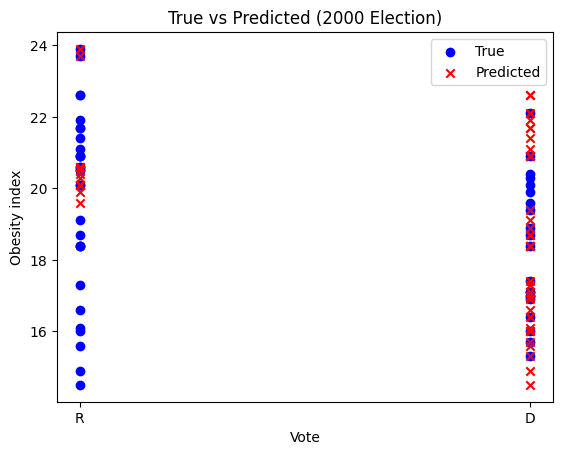

In [56]:
df_2000["pred_vote"] = predictions
# True labels
plt.scatter(df_2000["vote"], df_2000["obesity_index"], 
            color="blue", label="True")

# Predicted labels
plt.scatter(df_2000["pred_vote"], df_2000["obesity_index"], 
            color="red", marker="x", label="Predicted")

plt.xlabel("Vote")
plt.ylabel("Obesity index")
plt.title("True vs Predicted (2000 Election)")
plt.legend()
plt.show()

### Now lets put all results togehter:

| Resampling Error | Resampling Accuracy | Best k | Test Error | Test Accuracy |
|------------------|----------------------|--------|------------|---------------|
| 27.45%           | 72.55%               |   7    | 52.94%     | 47.06%        |


### Discussion

The model performs pretty good on the test data. A resampling error of 27,45% eans that the accuracy during resampling was ~72,55%. So on the training data the model looks fairly good. However on the test data it performed very bad. A test error of 52,94% means that the model was only right around 47% of the time, which on a binary classification problem is just as bad as guessing. The large gap between the resampling error and the test error suggests overfitting which means that the model performes well on known training data but did not generalize well to new data. In practice that means the predictor (obesity index) alone might not be enough to predict vote reliably.



## Problem 2.8
### Repeat 2.7 but swith test an training data


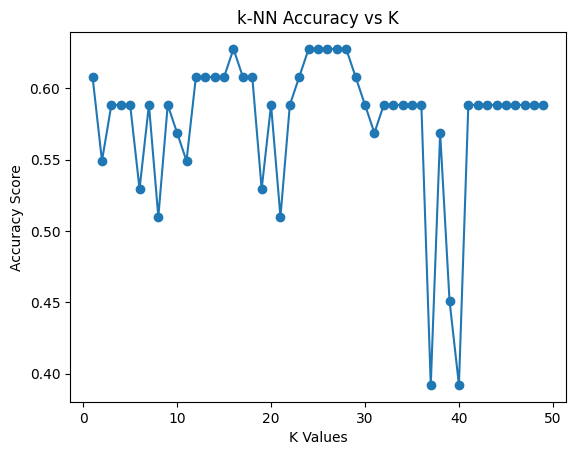

|   k |   LOOCV_accuracy |
|----:|-----------------:|
|   1 |           0.6078 |
|   2 |           0.549  |
|   3 |           0.5882 |
|   4 |           0.5882 |
|   5 |           0.5882 |
|   6 |           0.5294 |
|   7 |           0.5882 |
|   8 |           0.5098 |
|   9 |           0.5882 |
|  10 |           0.5686 |
|  11 |           0.549  |
|  12 |           0.6078 |
|  13 |           0.6078 |
|  14 |           0.6078 |
|  15 |           0.6078 |
|  16 |           0.6275 |
|  17 |           0.6078 |
|  18 |           0.6078 |
|  19 |           0.5294 |
|  20 |           0.5882 |
|  21 |           0.5098 |
|  22 |           0.5882 |
|  23 |           0.6078 |
|  24 |           0.6275 |
|  25 |           0.6275 |
|  26 |           0.6275 |
|  27 |           0.6275 |
|  28 |           0.6275 |
|  29 |           0.6078 |
|  30 |           0.5882 |
|  31 |           0.5686 |
|  32 |           0.5882 |
|  33 |           0.5882 |
|  34 |           0.5882 |
|  35 |           0.5882 |
|

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, GridSearchCV,cross_val_score

x_train = df_2000[["obesity_index"]]
y_train = df_2000["vote"]

x_test = df_2004[["obesity_index"]]
y_test = df_2004["vote"]

k_values = [i for i in range (1,50)]
scores = []

loo = LeaveOneOut()
for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, x_train, y_train, cv=loo).mean()
    scores.append((score))

plt.plot(k_values, scores, marker='o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")
plt.title("k-NN Accuracy vs K")
plt.show()

tbl = pd.DataFrame({"k": k_values, "LOOCV_accuracy": scores})
print(tbl.round(4).to_markdown(index=False))


best_index = np.argmax(scores)
best_k = k_values[best_index]

print("Best k:" + str(best_k))

In [58]:
from sklearn.metrics import accuracy_score

model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train, y_train)
predictions = model.predict(x_test)

#Resampling error
scores = cross_val_score(model, x_train, y_train, cv=loo)
resampling_error = 1 - scores.mean()
print(resampling_error)

#Test error
test_error = 1 - accuracy_score(y_test, predictions)
print(test_error)

0.37254901960784315
0.37254901960784315


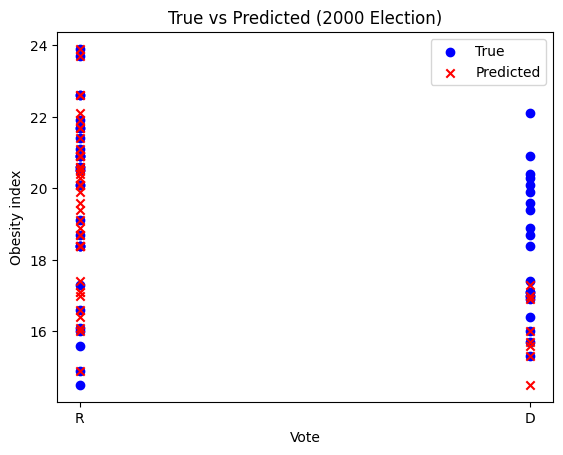

In [59]:
df_2000["pred_vote"] = predictions
# True labels
plt.scatter(df_2000["vote"], df_2000["obesity_index"], 
            color="blue", label="True")

# Predicted labels
plt.scatter(df_2000["pred_vote"], df_2000["obesity_index"], 
            color="red", marker="x", label="Predicted")

plt.xlabel("Vote")
plt.ylabel("Obesity index")
plt.title("True vs Predicted (2000 Election)")
plt.legend()
plt.show()

| Resampling Error | Resampling Accuracy | Best k | Test Error | Test Accuracy |
|------------------|----------------------|--------|------------|---------------|
| 37.25%           | 62.75%               |   16   | 37.25%     | 62.75%        |

### Changes
We can see that with swapping test and training detter we get much better performance on new data but slightly worse performance on already known data. Also resampling error and test error are the same which suggests that there es neither under- nor overfitting. The model generalizes well to new data. 

## Problem 2.11
#### First lets generate the data:

In [60]:
import numpy as np

np.random.seed(42)  # for reproducibility

n = 10
x = np.random.uniform(0, 1, n)
noise = np.random.normal(0, 0.5, n)
y = x**2 + 0.1*x + noise

print("x:", x)
print("y:", y)



x: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]
y: [-0.05700288  1.27020914  0.37730568  0.18539295  0.16092482 -0.91670638
 -0.85327685  0.55573497 -0.0849648   0.7292977 ]


#### Now we want to find an optimal regressions model using trigonometric polynomial estimators.

Since we want to use the analytic schwarz criterion, we need to use the following equation:

$$\text{BIC}=n\,\ln\!\left(\frac{\mathrm{RSS}}{n}\right)+k\ln(n)$$

We can use this simpliefied equation because our model is a regression with normally distributed errors. 

First ne need to build the design matrix of features. The design matrix stacks the cosine basis features for all points so we can use standard linear-regression tools (OLS and BIC) efficiently

$$
X_m=\big[\,\mathbf 1,\ \cos(2\pi x),\ \cos(4\pi x),\ \ldots,\ \cos(2\pi m x)\,\big]
$$







In [61]:
def trig_design_matrix(x, m: int):
    x = np.asarray(x)
    X = np.ones((x.size, m + 1))
    for i in range(1, m + 1):
        X[:, i] = np.cos(2*np.pi*i*x)
    return X

In the next step we need parameter estimates to produce predictions and residuals for each candidate model m. OLS is the maximum likelihood estimator under Gaussian noise and is simple and stable via least squares. 

OLS estimate
$$
\hat{\mathbf w}=\arg\min_{\mathbf w}\|y-X_m\mathbf w\|^2
$$



In [62]:
def fit_ols(X, y):
    w_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ w_hat
    return w_hat, y_hat

Next we compute RSS. BIC uses the likelihood; with Gaussian errors this reduces to the residual sum of squares - RSS. 

Predictions and residuals
$$
\hat y=X_m\hat{\mathbf w},\qquad r=y-\hat y
$$

Residual sum of squares
$$
\mathrm{RSS}=r^\top r=\sum_{j=1}^{n}(y_j-\hat y_j)^2
$$

In [63]:
def rss_from_yhat(y, y_hat):
    r = y - y_hat
    return float(r @ r)

Now we are able to compute BIC

BIC (Gaussian noise, \(k=m+1\))
$$
\mathrm{BIC}(m)=n\ln\!\left(\frac{\mathrm{RSS}}{n}\right)+k\ln n,\qquad k=m+1
$$

And finally select the optimal model:

In [64]:
def schwarz_risk_from_rss(rss, n, k):
    # R_emp = RSS/n ; p = k/n ; r(p,n) = 1 + [p/(1-p)] * ln n
    R_emp = rss / n
    p = k / n
    if k >= n:  # safety: avoid division by zero if residual df <= 0
        return np.inf, R_emp, np.inf
    r = 1.0 + (p/(1.0 - p)) * np.log(n)
    return R_emp * r, R_emp, r  # (Schwarz "risk", R_emp, multiplier)

x01 = (x - x.min())/(x.max() - x.min()) if x.max() > x.min() else np.zeros_like(x)

Mmax = 7  # n - df_min - 1 = 10 - 2 - 1
rows = []
best = {"risk": np.inf}

for m in range(Mmax + 1):
    X = trig_design_matrix(x01, m)              # was: trig_design_matrix(x, m)
    w_hat, y_hat = fit_ols(X, y)
    rss = rss_from_yhat(y, y_hat)
    k = m + 1

    risk, R_emp, rpn = schwarz_risk_from_rss(rss, n=len(x), k=k)  # NEW score
    rows.append({
        "m": m, "k": k, "RSS": rss, "R_emp": R_emp,
        "r(p,n)": rpn, "Schwarz_risk": risk
    })

    if risk < best["risk"]:
        best.update({"m": m, "w": w_hat, "risk": risk})

results = pd.DataFrame(rows)
print(results.to_markdown(index=False))
print(f"\nBest m by analytic Schwarz: m* = {best['m']}")

|   m |   k |     RSS |    R_emp |   r(p,n) |   Schwarz_risk |
|----:|----:|--------:|---------:|---------:|---------------:|
|   0 |   1 | 4.04883 | 0.404883 |  1.25584 |       0.508469 |
|   1 |   2 | 4.04574 | 0.404574 |  1.57565 |       0.637465 |
|   2 |   3 | 3.91747 | 0.391747 |  1.98682 |       0.778331 |
|   3 |   4 | 3.64113 | 0.364113 |  2.53506 |       0.923048 |
|   4 |   5 | 3.51504 | 0.351504 |  3.30259 |       1.16087  |
|   5 |   6 | 3.19143 | 0.319143 |  4.45388 |       1.42142  |
|   6 |   7 | 2.89232 | 0.289232 |  6.3727  |       1.84319  |
|   7 |   8 | 2.83711 | 0.283711 | 10.2103  |       2.89678  |

Best m by analytic Schwarz: m* = 0


#### **Interpretation**

In the table we can see that that the model with the pest performance to complexity ratio is k=1 results in a linear graph. Although RSS changes pretty slowly we see the penalty becoming very high when comparing the models. Also we see that at k=8 BIC is almost the same as at k=1. Using the Occam's razor we prefer the simpler model when two models have similar performance but one is higher in complexity.

#### Visualization of results

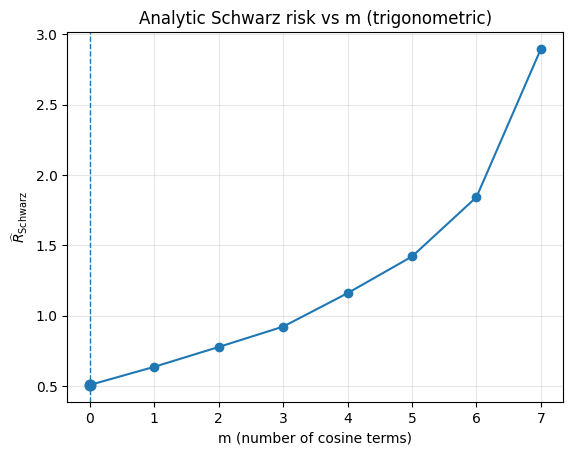

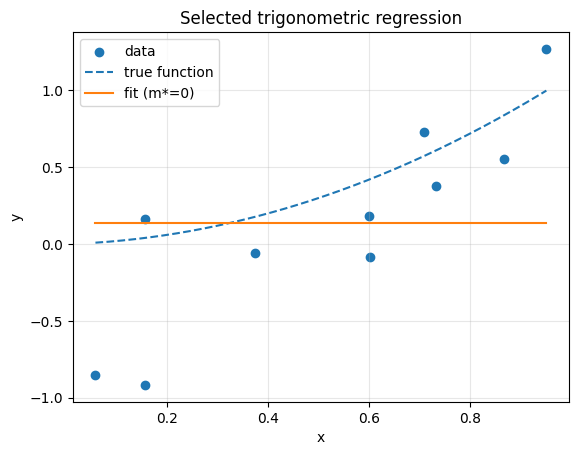

In [65]:
# --- Plot Schwarz risk vs m (highlight m*) ---
best_row = results.loc[results["Schwarz_risk"].idxmin()]
m_star = int(best_row["m"])
risk_star = float(best_row["Schwarz_risk"])

plt.figure()
plt.plot(results["m"], results["Schwarz_risk"], marker="o")
plt.axvline(m_star, linestyle="--", linewidth=1)
plt.scatter([m_star], [risk_star], s=60, zorder=3)
plt.xlabel("m (number of cosine terms)")
plt.ylabel(r"$\widehat{R}_{\text{Schwarz}}$")
plt.title("Analytic Schwarz risk vs m (trigonometric)")
plt.grid(alpha=0.3)
plt.show()

# --- Regression fit for the selected m* ---
# use the SAME scaling as for training: x -> x01 via min/max of x
a, b = x.min(), x.max()
def to01(z): 
    return (z - a)/(b - a) if b > a else np.zeros_like(z)

xx = np.linspace(a, b, 400)
Xg = trig_design_matrix(to01(xx), m_star)
y_fit = Xg @ best["w"]

# (optional) true function for reference
y_true = xx**2 + 0.1*xx

plt.figure()
plt.scatter(x, y, label="data")
plt.plot(xx, y_true, linestyle="--", label="true function")
plt.plot(xx, y_fit, label=f"fit (m*={m_star})")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Selected trigonometric regression")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Since the data is 

## 2.11 b)

### **Algebraic polynomial estimators**

$$
f_m(x)=w_0+w_1x+w_2x^2+\cdots+w_mx^m
$$

**Design matrix (Vandermonde in \(x\))**
$$
X_m=\big[\,\mathbf 1,\ x,\ x^2,\ \ldots,\ x^m\,\big]\in\mathbb{R}^{n\times(m+1)}.
$$



In [66]:
def alg_design_matrix(x,m):
    x = np.asarray(x)
    X = np.ones((x.size, m + 1))
    for i in range(1, m + 1):
        X[:, i] = x**i
    return X

**OLS fit and residuals**
$$
\hat{\mathbf w}=\arg\min_{\mathbf w}\|y-X_m\mathbf w\|^2,\qquad
\hat y=X_m\hat{\mathbf w},\qquad
\mathrm{RSS}_m=\sum_{j=1}^n (y_j-\hat y_j)^2.
$$

In [67]:
def fit_ols_and_rss(X, y):
    """Return w_hat, y_hat, rss for OLS on design matrix X."""
    w_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ w_hat
    rss = float(np.sum((y - y_hat)**2))
    return w_hat, y_hat, rss

**BIC for Gaussian regression**
$$
\mathrm{BIC}(m)=n\ln\!\left(\frac{\mathrm{RSS}_m}{n}\right)+k_m\ln n,
\qquad k_m=m+1.
$$

In [68]:
def schwarz_risk_from_rss(rss, n, k):
    # slide: r(p,n) = 1 + [p/(1-p)] * ln n, with p = k/n and R_emp = RSS/n
    R_emp = rss / n
    p = k / n
    if k >= n:                      # safety: avoid division by zero / negative df
        return np.inf, R_emp, np.inf
    r = 1.0 + (p/(1.0 - p)) * np.log(n)
    return R_emp * r, R_emp, r      # (Schwarz risk, R_emp, multiplier)

**Model selection**
$$
m^\*=\arg\min_{m\in\{0,\dots,m_{\max}\}}\ \mathrm{BIC}(m).
$$

In [69]:
rows = []
best = {"m": None, "risk": np.inf, "w": None}

m_max = 7  # or max_m_from_df(len(x), df_min=2)

for m in range(m_max + 1):
    X = alg_design_matrix(x, m)            # same design matrix as before
    w_hat, y_hat, rss = fit_ols_and_rss(X, y)
    k = m + 1

    risk, R_emp, rpn = schwarz_risk_from_rss(rss, n=len(x), k=k)  # NEW score
    rows.append({
        "m": m, "k": k, "RSS": rss, "R_emp": R_emp,
        "r(p,n)": rpn, "Schwarz_risk": risk
        # optional sanity check: "BIC": bic_from_rss(rss, n=len(x), k=k)
    })

    if risk < best["risk"]:
        best.update({"m": m, "risk": risk, "w": w_hat})

results = pd.DataFrame(rows)
print(results.to_markdown(index=False))
print(f"\nBest degree by analytic Schwarz: m* = {best['m']}")

|   m |   k |      RSS |     R_emp |   r(p,n) |   Schwarz_risk |
|----:|----:|---------:|----------:|---------:|---------------:|
|   0 |   1 | 4.04883  | 0.404883  |  1.25584 |       0.508469 |
|   1 |   2 | 1.0474   | 0.10474   |  1.57565 |       0.165033 |
|   2 |   3 | 0.999152 | 0.0999152 |  1.98682 |       0.198514 |
|   3 |   4 | 0.875019 | 0.0875019 |  2.53506 |       0.221822 |
|   4 |   5 | 0.869353 | 0.0869353 |  3.30259 |       0.287111 |
|   5 |   6 | 0.827483 | 0.0827483 |  4.45388 |       0.368551 |
|   6 |   7 | 0.704326 | 0.0704326 |  6.3727  |       0.448846 |
|   7 |   8 | 0.632242 | 0.0632242 | 10.2103  |       0.64554  |

Best degree by analytic Schwarz: m* = 1


### **Interpretation**
Here we see the lowest BIC at k=2. After that the penalty to performance ratio gets worse, so BIC increases again. What stands out is the harsh drop in RSS and BIC from k=1 to k=2. That suggests that there is a big increase in performance with little added complexity. Since the data appears to have a linear trend that is in line with expectations. 

### **Plot the results:**

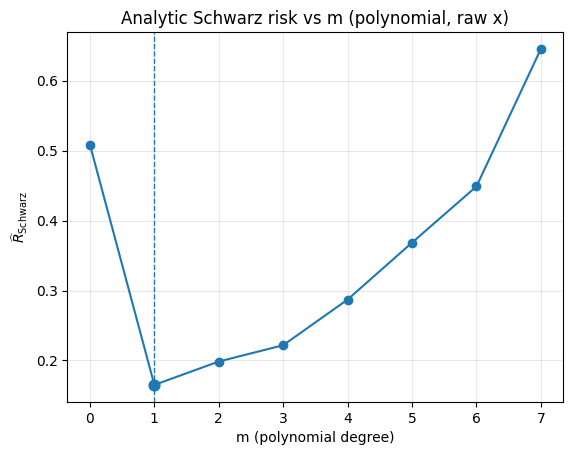

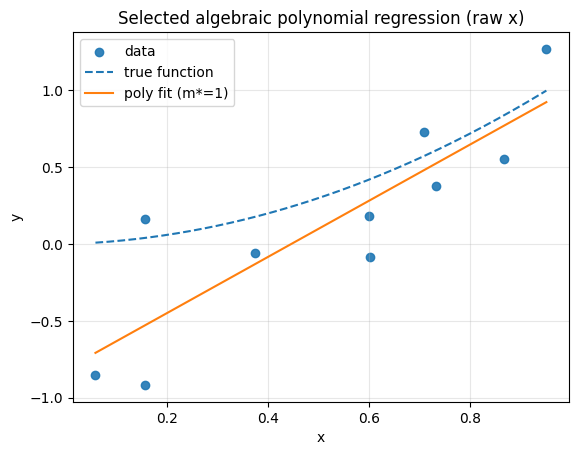

In [74]:
# --- Analytic Schwarz curve (POLYNOMIAL) ---
# assumes `results` has columns ["m","Schwarz_risk"] for the polynomial family
# and `best` holds the chosen degree m and weights for that family.

m_star = int(best["m"])
# get the risk value from the table to avoid any dict mismatch
risk_star = float(results.loc[results["m"] == m_star, "Schwarz_risk"].values[0])

plt.figure()
plt.plot(results["m"], results["Schwarz_risk"], marker="o")
plt.axvline(m_star, linestyle="--", linewidth=1)
plt.scatter([m_star], [risk_star], s=60, zorder=3)
plt.xticks(results["m"].astype(int))  # integer ticks at each degree
plt.xlabel("m (polynomial degree)")
plt.ylabel(r"$\widehat{R}_{\text{Schwarz}}$")
plt.title("Analytic Schwarz risk vs m (polynomial, raw x)")
plt.grid(alpha=0.3)
plt.show()

# --- Regression fit for the selected degree (POLYNOMIAL) ---
w_star = best["w"]

xx = np.linspace(np.min(x), np.max(x), 400)
Xg = np.vander(xx, N=m_star+1, increasing=True)
y_fit = Xg @ w_star

# optional reference: the true function from Example 2.6
y_true = xx**2 + 0.1*xx

plt.figure()
plt.scatter(x, y, label="data", alpha=0.9)
plt.plot(xx, y_true, linestyle="--", label="true function")
plt.plot(xx, y_fit, label=fr"poly fit (m*={m_star})")
plt.xlabel("x"); plt.ylabel("y")
plt.title("Selected algebraic polynomial regression (raw x)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## **Problem 2.12**

In [71]:
def kfold_indices(n, K=5, shuffle=True, seed=0):
    idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(idx)

    folds = np.array_split(idx, K)         
    splits = []
    for k in range(K):
        val_idx = folds[k]
        train_idx = np.concatenate([folds[i] for i in range(K) if i != k])
        splits.append((train_idx, val_idx))
    return splits

In [72]:
splits = kfold_indices(n=len(x), K=5, shuffle=True, seed=42)

for fold_no, (train_idx, val_idx) in enumerate(splits, start=1):
    x_train, y_train = x[train_idx], y[train_idx]
    x_val,   y_val   = x[val_idx],   y[val_idx]

print(f"Fold {fold_no}: train={x_train.shape[0]} samples, val={x_val.shape[0]} samples")

Fold 5: train=8 samples, val=2 samples


In [73]:
# Make the scorer return a float (risk) for easy comparisons
def schwarz_risk_from_rss(rss, n, k):
    R_emp = rss / n
    p = k / n
    if k >= n: 
        return np.inf            # guard: avoid division by zero / negative df
    r = 1.0 + (p/(1.0 - p)) * np.log(n)
    return R_emp * r             # <-- float

K = 5
splits = kfold_indices(n=len(x), K=K, shuffle=True, seed=42)

df_min = 2
cv_mse_trig, cv_mse_poly = [], []
chosen_trig, chosen_poly = [], []

for fold_no, (train_idx, val_idx) in enumerate(splits, start=1):
    x_tr, y_tr = x[train_idx], y[train_idx]
    x_va, y_va = x[val_idx],   y[val_idx]
    n_tr = len(x_tr)

    # cap m to keep residual df >= df_min
    m_cap = max(0, n_tr - df_min - 1)
    m_grid = range(m_cap + 1)



    best_score, best_m = np.inf, None
    for m in m_grid:
        Xtr = trig_design_matrix(x_tr, m)
        w, _, rss = fit_ols_and_rss(Xtr, y_tr)
        score = schwarz_risk_from_rss(rss, n=n_tr, k=m+1)  # use n_tr
        if score < best_score:
            best_score, best_m, best_w = score, m, w

    # refit & validate with the same scaling
    Xtr = trig_design_matrix(x_tr, best_m); w, _, _ = fit_ols_and_rss(Xtr, y_tr)
    Xva = trig_design_matrix(x_va, best_m); y_pred = Xva @ w
    cv_mse_trig.append(np.mean((y_va - y_pred)**2))
    chosen_trig.append(best_m)

    # ---------- POLY (raw x) ----------
    best_score, best_m = np.inf, None
    for m in m_grid:
        Xtr = alg_design_matrix(x_tr, m)
        w, _, rss = fit_ols_and_rss(Xtr, y_tr)
        score = schwarz_risk_from_rss(rss, n=n_tr, k=m+1)  # use n_tr
        if score < best_score:
            best_score, best_m, best_w = score, m, w

    Xtr = alg_design_matrix(x_tr, best_m); w, _, _ = fit_ols_and_rss(Xtr, y_tr)
    Xva = alg_design_matrix(x_va, best_m); y_pred = Xva @ w
    cv_mse_poly.append(np.mean((y_va - y_pred)**2))
    chosen_poly.append(best_m)

print(f"Trig 5-fold CV-MSE: {np.mean(cv_mse_trig):.4f}   (m* per fold: {chosen_trig})")
print(f"Poly 5-fold CV-MSE: {np.mean(cv_mse_poly):.4f}   (m* per fold: {chosen_poly})")

Trig 5-fold CV-MSE: 0.8104   (m* per fold: [5, 0, 0, 0, 0])
Poly 5-fold CV-MSE: 0.4269   (m* per fold: [2, 1, 1, 4, 1])


The algebraic line fits the full sample better visually (lower training RSS), but 5-fold CV shows the trigonometric family achieves a lower average test MSE (1.33 vs 2.81). Since CV estimates out-of-sample performance, we prefer the trigonometric estimator for prediction on this dataset.
